This code is to optimize TDA.ipynb file, the main change is using three main function as the filter function:
1. eccentricity
2. PCA
3. KDE

In [ ]:
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
analyze_path = os.path.join(parent_dir, "utils")

os.chdir(analyze_path)

import ast
import pandas as pd
import numpy as np

import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tdam.cover import CubicalCover
from tdam.clustering import FailSafeClustering
from tdam.core_old import MapperAlgorithm
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, normalize

In [ ]:
import geopandas as gpd
from shapely import wkt

TM2 = 3826
taiwan = gpd.read_file('../Data/OFiles_9e222fea-bafb-4436-9b17-10921abc6ef2/TOWN_MOI_1140318.shp')
taiwan = taiwan[(~taiwan['TOWNNAME'].isin(['旗津區', '頭城鎮', '蘭嶼鄉', '綠島鄉', '琉球鄉'])) & 
                (~taiwan['COUNTYNAME'].isin(['金門縣', '連江縣', '澎湖縣']))].to_crs(TM2)
taiwan_cnty = taiwan[['COUNTYNAME','geometry']].dissolve(by='COUNTYNAME')
taiwan_cnty['geometry'] = taiwan_cnty.buffer(0)

# 原始以 0.001 grid 計算出的區域事故及對應索引, 依照 hex_grid 計算出來的GI
grid_gi_df = pd.read_csv('../ComputedData/Grid/grid_gi.csv')
grid_gi_df['accident_indices'] = grid_gi_df['accident_indices'].apply(ast.literal_eval)
grid_gi_df['geometry'] = grid_gi_df['geometry'].apply(wkt.loads)
grid_gi  = gpd.GeoDataFrame(grid_gi_df, geometry='geometry').set_crs(TM2, allow_override=True)
grid_gi['geometry'] = grid_gi.geometry.centroid

county_join = gpd.sjoin(grid_gi[['geometry']], taiwan_cnty, how='left', predicate='within')
grid_gi['COUNTYNAME'] = county_join['COUNTYNAME']

grid_filter = grid_gi[grid_gi['accident_indices'].str.len() > 0]
grid_filter.reset_index(inplace=True)

In [ ]:
all_features_df = pd.read_csv("../ComputedData/ForModel/all_featuresV2.csv")
cols = all_features_df.columns[all_features_df.columns.str.contains('事故位置大類別名稱')] # 高共線
all_features_df.drop(columns=cols, inplace=True)

In [ ]:
def linf_centrality_exact(df, block_size = 2000):
    """
    回傳 shape=(n,1) 的 L∞ centrality（每點到最遠點的距離）。
    - metric: "cosine" 或 "euclidean"
    - block_size: 控制記憶體 (block_size * n distances)
    """
    X = df.to_numpy(dtype=float)
    n = X.shape[0]
    # 對每一列作 L2 正規化才能用 cosine 距離
    X = normalize(X, norm="l2", axis=1)

    # 準備結果陣列，初始為無窮小
    max_d = np.full(n, -np.inf, dtype=float)
    order = np.arange(n) # 保留原順序
    
    # 分塊計算 pairwise 距離以控制記憶體
    for start in range(0, n, block_size):
        idx = order[start:start+block_size]
        D_blk = pairwise_distances(X[idx], X, metric='cosine')  # (b, n)
        # 自身距離設為 -inf，避免影響 max
        D_blk[np.arange(D_blk.shape[0]), idx] = -np.inf
        # 針對每個 i（在 idx 中），更新它的全域最遠距離
        max_d[idx] = np.maximum(max_d[idx], D_blk.max(axis=1))

    return max_d.reshape(-1, 1)

## 1. PCA

In [ ]:
pc=5
filter_pca = PCA(pc).fit_transform(all_features_df)

pca = PCA(pc).fit(all_features_df)
ratios = pca.explained_variance_ratio_
print(ratios)
print(ratios.sum()) 
# pc_z = StandardScaler().fit_transform(filter_pca[:, :pc])

## 2. KDE

In [ ]:
X = filter_pca # pc_z
kde = KernelDensity(kernel='gaussian').fit(X)

log_density = kde.score_samples(X)

density = np.exp(log_density)
# rank-normalize
rank = (np.argsort(np.argsort(density)).astype(float) / (len(density)-1))
filter_kde = rank.reshape(-1, 1) 
# kde_z = StandardScaler().fit_transform(filter_kde)

### check for correlation
lin = LinearRegression().fit(X, filter_kde.ravel())
print("Linear R^2 (PC1-5 -> KDE) =", lin.score(X, filter_kde.ravel()))

## 3. Centrality

In [ ]:
print('Centrality')
filter_centrality = linf_centrality_exact(all_features_df)
# linf_z = StandardScaler().fit_transform(filter_centrality)

# filter_full = np.concatenate([linf_z, kde_z, pc_z], axis=1)
filter_full = np.concatenate([filter_centrality, filter_kde, filter_pca], axis=1)

In [ ]:
filter_full = pd.DataFrame(filter_full, columns=['centrality', 'kde', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5'])
filter_full.to_csv("../ComputedData/ForModel/filtered_data.csv", index=False)

# Mapper

In [ ]:
filter_full = pd.read_csv("../ComputedData/ForModel/filtered_data.csv")
filter_full.drop(columns=['pc4', 'pc5'], inplace=True)
filter_full.shape

In [ ]:
overlaps = [2, 3]
intervals = [8, 10]
detailed_results = []
silhouette_for_intervals = []

for overlap in overlaps:
    for interval in intervals:
        print(f"Processing overlap {overlap}, interval {interval}")
        mapper_algo = MapperAlgorithm(
            cover=CubicalCover(
                n_intervals=interval,
                overlap_frac=overlap / 10
            ),
            clustering=FailSafeClustering(
                KMeans(
                    n_clusters=2,
                    random_state=42
                )
            ),
            n_jobs=-1
        )

        mapper_info = mapper_algo.fit_transform(all_features_df.to_numpy(), filter_full)

        silhouette_for_intervals.append(mapper_info[1])
        result = {
            "overlap": overlap,
            "interval": interval,
            "silhouette": mapper_info[1],
            "mapper_info": mapper_info
        }
        detailed_results.append(result)

        with open(f"../ComputedData/ForMatrixV2/o{overlap}i{interval}.pkl", 'wb') as file:
            pickle.dump(result, file)

detailed_results_df = pd.DataFrame(detailed_results)

In [ ]:
col = '道路類別'

def get_max_categories(row):

    cols = all_features_df.columns[all_features_df.columns.str.contains(col)]

    max_val = row[cols].max()
    max_cols = row[cols][row[cols] == max_val].index
    # 取底線後面的類別名稱，用逗號串起來
    return ','.join(col.split('_')[-1] for col in max_cols)

all_features_df['最高類別'] = all_features_df.apply(get_max_categories, axis=1)
all_features_df['最高類別'].value_counts()

In [13]:
all_features_df['county'] = grid_filter['COUNTYNAME']
all_features_df['hotspot'] = grid_filter['hotspot']
all_features_df['hotspot'] = all_features_df['hotspot'].apply(lambda x: 'Hotspot' if 'Hotspot' in str(x) else 'Not Hotspot')
all_features_df['facility'] = all_features_df[['youbike_100m_count_mean', 'mrt_100m_count_mean', 'parkinglot_100m_count_mean']].apply(
    lambda row: '1' if (row > 0).any() else '0', axis=1
)
all_features_df['hotspot_facility'] = all_features_df['hotspot'] + '_' + all_features_df['facility']
all_features_df['county_city'] = all_features_df['county'].apply(lambda x: 'City' if '市' in str(x) else 'County')

all_features_df_speed = pd.read_csv('../ComputedData/ForModel/all_features_df-速限.csv')
all_features_df['original_speed'] = all_features_df_speed['速限-第1當事者_mean']

In [19]:
from collections import Counter

def avg_label(data):
    return sum(data) / len(data) if len(data) > 0 else 0

def most_common_encoded_label(data):
    return Counter(data).most_common(1)[0][0]

# conditional probability
def cond_prob_mixed(subdf, a_col, a_is, b_col, b_rule=">0", alpha=0.5, min_den=0):
    """
    回傳 P(B | A) ，其中：
    - A : 類別欄位, a_is 可為 str 或 可迭代(多類別集合)
    - B : 可為數值/比例欄位，用 b_rule 指定成立條件(或傳入 callable)
    alpha : Laplace smoothing
    min_den : A 成立的樣本至少要有幾個，否則回 NaN
    """
    Aset = {a_is} if isinstance(a_is, str) else set(a_is)
    A = subdf[a_col].astype(str)
    mask_A = A.isin(Aset)

    if mask_A.sum() < min_den:
        return float('nan')

    s = pd.to_numeric(subdf[b_col], errors='coerce')  # 比例/數值
    if callable(b_rule):
        mask_B = b_rule(s)  # 例如：lambda x: x >= 0.2
    else:
        rule = str(b_rule).strip()
        if rule == ">0":
            mask_B = (s > 0)
        elif rule == ">=0":
            mask_B = (s >= 0)
        elif rule.startswith(">="):
            thr = float(rule[2:]); mask_B = (s >= thr)
        elif rule.startswith(">"):
            thr = float(rule[1:]); mask_B = (s > thr)
        elif rule.startswith("<="):
            thr = float(rule[2:]); mask_B = (s <= thr)
        elif rule.startswith("<"):
            thr = float(rule[1:]); mask_B = (s < thr)
        elif rule.startswith("=="):
            thr = float(rule[2:]); mask_B = (s == thr)
        else:
            raise ValueError("Unknown b_rule")

    num = (mask_A & mask_B).sum()
    den = mask_A.sum()
    return float((num + alpha) / (den + 2 * alpha))

def node_cond_prob(subdf):
    return cond_prob_mixed(
        subdf=subdf,
        # 有設施的情況下為熱點的機率
        a_col='hotspot', a_is='Hotspot',
        b_col='facility', b_rule='>0',
        # 行車管制號誌的情況下為熱點的機率
        # a_col='hotspot', a_is='Hotspot',
        # b_col='號誌-號誌種類名稱_行車管制號誌', b_rule='>0',
        # 無路面邊線的情況下為熱點的機率
        # a_col='hotspot', a_is='Hotspot',
        # b_col='車道劃分設施-分道設施-路面邊線名稱_無', b_rule='>0',
        alpha=0.5
    )

# use this for finding specific value ratios in a column
def ratio_in_data(data, col='county_city', values='City'):

    import pandas as pd

    # 取出要判斷的 Series
    if isinstance(data, pd.DataFrame):
        s = data[col].astype(str)
    else:
        s = pd.Series(data).astype(str)

    # 正規化欲比對的值集合
    if isinstance(values, (list, tuple, set)):
        target = set(map(str, values))
        mask = s.isin(target)
    else:
        mask = (s == str(values))

    return float(mask.mean())


**node_cond_prob**
條件機率
- ('hotspot', '號誌-號誌種類名稱_行車管制號誌')
- ('hotspot', '車道劃分設施-分道設施-路面邊線名稱_無')
- ('hotspot', 'facility')

**most_common_encoded_label**
最常出現的值
- 'hotspot_facility'

**ratio_in_data**
在特定欄位中的值出現的比例，例如縣市中'市'的比例
- 'county_city'

**avg_label**
節點中平均值
- original_speed

Creating spring layout...
Mapper layout computed. nodes=1501
Data extracted.
Mapping colors...
Colors mapped.
Plotting...


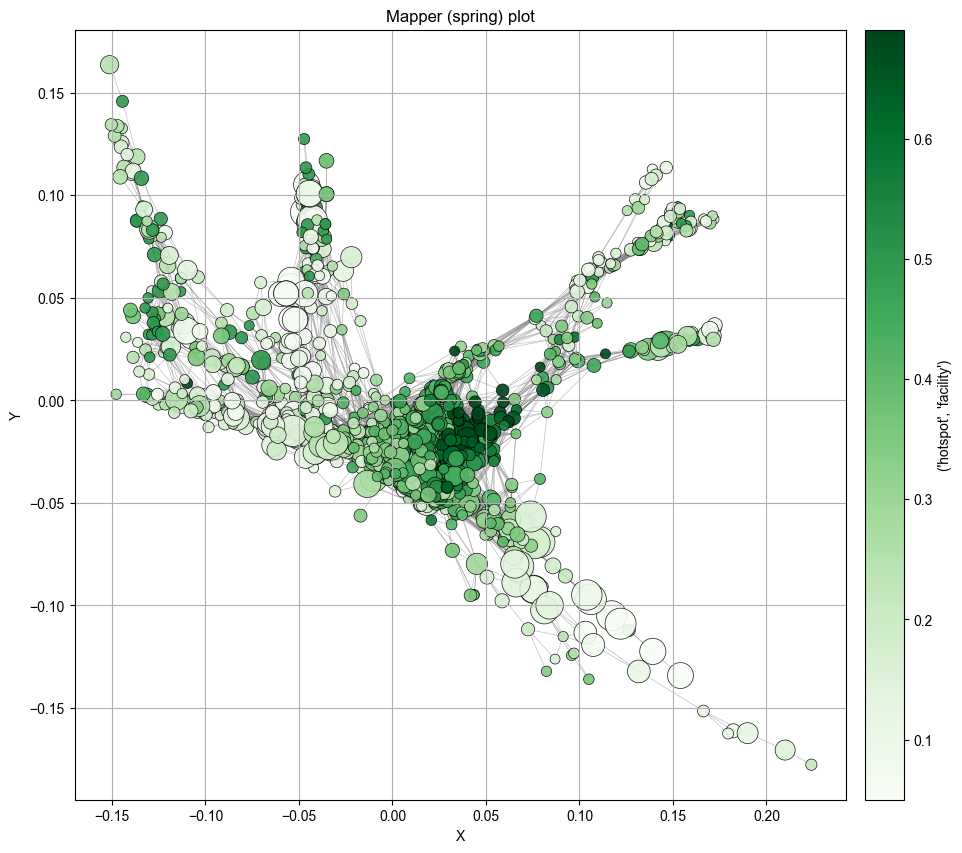

In [ ]:
from TrafficTDApythonUtils.plotsv2 import MapperPlotterSpring

overlaps = [3]
intervals = [10]
seeds = [47]
# seeds = [i for i in range(10, 50)]
choose = ('hotspot', 'facility')

for seed in seeds:
    for overlap in overlaps:
        for interval in intervals:
            detailed_results_df = pickle.load(open(f"../ComputedData/ForMatrixV2/o{overlap}i{interval}.pkl", "rb"))
            mapper_plotter = MapperPlotterSpring(
                detailed_results_df['mapper_info'],
                all_features_df,
                seed=seed, iterations=130, dim=2,
                range_lst=[-0.5, 0.5, 0.5, -0.5],
                cmap="Greens",
                encoded_label=node_cond_prob
                # encoded_label=most_common_encoded_label
                # encoded_label=ratio_in_data
                # encoded_label=avg_label
            )
            mapper_plotter.create_mapper_plot(choose, avg=True, size_threshold=50, plot_type='spring')
            full_info, outliers = mapper_plotter.extract_data()
            mapper_plotter.map_colors(threshold=0)
            mapper_plotter.plot(set_label=True, size=500, anchor=(0,0),
                                # save_path=f"../ComputedData/ForMatrixV2/Plots/o{overlap}i{interval}s{seed}_{choose}.png"
                                )
            # mapper_plotter.plot3d_matplotlib(
            #     choose,
            #     avg=False,
            #     save_path=f"../ComputedData/ForMatrixV2/Plots/o{overlap}i{interval}s{seed}_{choose}.png",
            #     size=1200, elev=22, azim=35, dpi=180
            # )
            # mapper_plotter.pvis(
            #     path="mapper_interactive.html",
            #     physics_mode="off",
            #     edge_length_from_layout=True,
            #     scale_xy=900,
            #     node_size_cap=20,
            #     open_browser=True
            # )

### Deprecated

In [ ]:
# overlaps = [4]
# intervals = [12]
# seeds = [i for i in range(55, 80)]

# for seed in [52]:
#     for overlap in overlaps:
#         for interval in intervals:
            
#             detailed_results_df = pickle.load(open(f"../ComputedData/ForMatrixV2/o{overlap}i{interval}.pkl", "rb"))
#             choose = 'hotspot_youbike' # county, hotspot_youbike
#             mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'], 
#                                         all_features_df, seed=seed, iterations=50, dim=2,
#                                             range_lst=[-0.5, 0.5, 0.5, -0.5])

#             def avg_label(data):
#                 return sum(data) / len(data) if len(data) > 0 else 0
#             def most_common_encoded_label(data):
#                 most_common_item = Counter(data).most_common(1)[0][0]
#                 return most_common_item

#             mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
#             full_info = mapper_plotter.extract_data()
#             mapper_plotter.map_colors(choose, size=30, threshold=0)
#             mapper_plotter.plot(choose, avg=False, set_label=True, size=500, anchor=1,
#                                 # save_path=f"../ComputedData/ForMatrixV2/Plots/o{overlap}i{interval}s{seed}_{choose}.png"
#                                 )